In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.ranker import generate_ranker_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ranker"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ranker']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-10 13:56:17.717357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 13:56:17.779097: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-10 13:56:18.186027: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_075


In [2]:
oof = pd.read_csv(f'/kaggle/output/{CFG["2nd_stage"]["execution"]["best_exp_id"]}/oof.csv')
oof = oof.rename(columns={"oof": "oof_stage2"})
sub = pd.read_csv(f'/kaggle/output/{CFG["regressor"]["execution"]["best_exp_id"]}/submission.csv')
sub.drop(columns=["oof_stage2"], inplace=True)
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(oof.head())
display(sub.head())
display(labels.head())

,series_id,oof_1st,step,oof_stage2,minutes
0,038441c925bb,0.999923,11.5,0.999923,NaN
1,038441c925bb,0.999829,35.5,0.999829,NaN
2,038441c925bb,0.994979,59.5,0.994979,NaN
3,038441c925bb,0.993882,83.5,0.993882,NaN
4,038441c925bb,0.993127,107.5,0.993127,NaN


,step,sub_step_before_modify,key_step,series_id,score,event,oof_regressor,target,minutes
0,4995,5039.0,5051.5,038441c925bb,0.834676,onset,-43.396847,-47.0,1857.5
1,10926,10895.0,10907.5,038441c925bb,0.754868,wakeup,31.542488,37.0,2337.5
2,20284,20375.0,20387.5,038441c925bb,0.630360,onset,-90.753082,-131.0,2937.5
3,27433,27455.0,27467.5,038441c925bb,0.880441,wakeup,-21.333181,37.0,2337.5
4,39988,40007.0,40019.5,038441c925bb,0.879920,onset,-18.495075,-11.0,297.5


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [3]:
# 周辺に予測を撒く
dfs = []
for level, diff in enumerate([0, -1, 1, -2, 2, -3, 3, -5, 5, -10, 10, -15, 15, -30, 30]):
    tmp = sub.copy()
    tmp["level"] = level
    tmp["step"] += CFG["feature"]["agg_freq"] * diff
    tmp["key_step"] += CFG["feature"]["agg_freq"] * diff
    tmp["sub_step_before_modify"] += CFG["feature"]["agg_freq"] * diff
    dfs.append(tmp)
sub = pd.concat(dfs, axis=0).reset_index(drop=True)
sub.sort_values(["series_id", "step", "level"], inplace=True)
sub = sub.drop_duplicates(["series_id", "step"], keep="first").reset_index(drop=True)
sub.head()

,step,sub_step_before_modify,key_step,series_id,score,event,oof_regressor,target,minutes,level
0,4275,4319.0,4331.5,038441c925bb,0.834676,onset,-43.396847,-47.0,1857.5,13
1,4635,4679.0,4691.5,038441c925bb,0.834676,onset,-43.396847,-47.0,1857.5,11
2,4755,4799.0,4811.5,038441c925bb,0.834676,onset,-43.396847,-47.0,1857.5,9
3,4875,4919.0,4931.5,038441c925bb,0.834676,onset,-43.396847,-47.0,1857.5,7
4,4923,4967.0,4979.5,038441c925bb,0.834676,onset,-43.396847,-47.0,1857.5,5


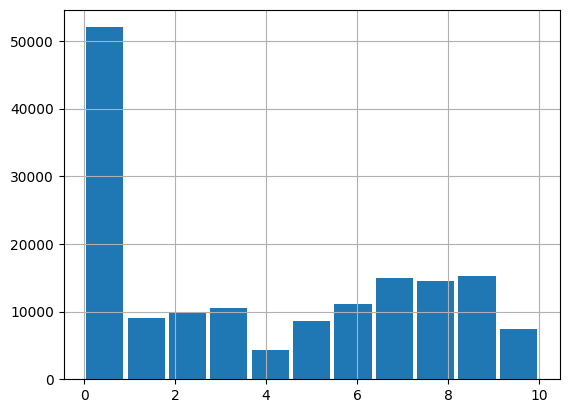

series_id                 5331720
step                      5331720
oof_stage2                5331720
minutes                    878146
target                     157575
sub_step                   157575
key_step                   157575
sub_step_before_modify     157575
event                      157575
level                      157575
score                      157575
oof_regressor              157575
dtype: int64
5.321978234105249


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,sub_step_before_modify,event,level,score,oof_regressor
0,038441c925bb,11.5,0.999923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,35.5,0.999829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,038441c925bb,59.5,0.994979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,038441c925bb,83.5,0.993882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,038441c925bb,107.5,0.993127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 正解ラベルを作成
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.zeros(len(sub_df))
    for thresh in thresholds:
        for step in label_df["step"].values:
            for idx, sub_step in enumerate(sub_df["step"].values):
                dist = abs(step - sub_step)
                if dist < thresh:
                    targets[idx] += 1
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

train = oof[["series_id", "step", "oof_stage2", "minutes"]].merge(
    sub[["target", "series_id", 
         "sub_step", "key_step", "sub_step_before_modify",
         "event", "level", "score", "oof_regressor"]], 
    left_on=["series_id", "step"], 
    right_on=["series_id", "key_step"], 
    how="left",
    )
print((~train.isna()).sum())
print((train.target ** 2).mean() ** 0.5)
display(train.head())

In [5]:
# # スコアの理論値(targetを完璧に当てれた場合)
# ideal_sub = sub.copy()
# ideal_sub["score"] = ideal_sub["target"]
# ideal_sub["step"] = ideal_sub["sub_step"]

# labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
# score, ap_table = compute_comptetition_metric(labels, ideal_sub)
# print(f"score: {score:.4f}")
# display(ap_table)

In [6]:
# 再現率
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    for thresh in thresholds:
        targets = np.zeros(len(label_df))
        for idx, step in enumerate(label_df["step"].values):           
            min_dist = thresh
            min_idx = -1            
            for sub_step in sub_df["step"].values:    
                dist = abs(step - sub_step)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = idx
            if min_idx != -1:
                targets[idx] = True
        label_df["target"] = targets
        label_df["threshold"] = thresh
        dfs.append(label_df.copy())
recall_df = pd.concat(dfs).reset_index(drop=True)
print(recall_df["target"].mean())
display(recall_df.groupby(["event", "threshold"])["target"].mean())

0.931434533124674


event   threshold
onset   12           0.771238
        36           0.885619
        60           0.925903
        90           0.931121
        120          0.940722
        150          0.946984
        180          0.954289
        240          0.957420
        300          0.960134
        360          0.964726
wakeup  12           0.768043
        36           0.903212
        60           0.948894
        90           0.954109
        120          0.958698
        150          0.964748
        180          0.970797
        240          0.972048
        300          0.974134
        360          0.975803
Name: target, dtype: float64

In [7]:
# 特徴生成
train, features = generate_ranker_features(train)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

100%|██████████| 277/277 [03:28<00:00,  1.33it/s]


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,sub_step_before_modify,event,level,...,for_pred_rolling_min_50_shift_100_diff,oof_stage2_rolling_median_50_shift_100_diff,oof_stage2_diff_abs_rolling_median_50_shift_100_diff,oof_stage2_mean_rolling_median_50_shift_100_diff,for_pred_rolling_median_50_shift_100_diff,oof_stage2_rolling_square_mean_50_shift_100_diff,oof_stage2_diff_abs_rolling_square_mean_50_shift_100_diff,oof_stage2_mean_rolling_square_mean_50_shift_100_diff,for_pred_rolling_square_mean_50_shift_100_diff,fold
0,038441c925bb,4331.5,0.999193,NaN,0.0,4275.0,4331.5,4319.0,onset,13.0,...,0.0,0.960272,-0.002529,0.742022,0.0,0.998246,-0.000057,0.929244,0.0,2
1,038441c925bb,4691.5,0.998122,NaN,1.0,4635.0,4691.5,4679.0,onset,11.0,...,0.0,0.959926,-0.003268,0.724258,0.0,0.998064,-0.000062,0.922430,0.0,2
2,038441c925bb,4811.5,0.993161,657.5,3.0,4755.0,4811.5,4799.0,onset,9.0,...,0.0,0.958227,-0.003156,0.717534,0.0,0.997701,-0.000078,0.918442,0.0,2
3,038441c925bb,4931.5,0.978979,1257.5,6.0,4875.0,4931.5,4919.0,onset,7.0,...,0.0,0.956779,-0.003403,0.710106,0.0,0.997368,-0.000110,0.908672,0.0,2
4,038441c925bb,4979.5,0.655212,1497.5,7.0,4923.0,4979.5,4967.0,onset,5.0,...,0.0,0.955628,-0.003881,0.709399,0.0,0.997191,-0.000128,0.904474,0.0,2


(157575, 1390)

In [8]:
# 学習
trn_oof, models = fit_xgb(
    X=train, 
    y=train["target"], 
    folds=train["fold"].astype(int), 
    features=features.all_features(),
    params=CFG["ranker"]["xgboost"], 
    es_rounds=100,
)
train["oof_ranker"] = trn_oof
train["score"] = train["oof_ranker"]
train["key_step"] = train["step"]
train["step"] = train["sub_step"].astype(int)
sub = train[["score", "key_step", "step", "event", "level", "series_id"]]

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))
with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:4.96301
[100]	eval-rmse:2.64463
[200]	eval-rmse:2.13794
[300]	eval-rmse:2.05522
[400]	eval-rmse:2.04110
[500]	eval-rmse:2.03970
[551]	eval-rmse:2.03991


 20%|██        | 1/5 [00:19<01:19, 19.93s/it]

== fold 1 ==
[0]	eval-rmse:4.96047
[100]	eval-rmse:2.66158
[200]	eval-rmse:2.12992
[300]	eval-rmse:2.02738
[400]	eval-rmse:2.00463
[500]	eval-rmse:1.99956
[600]	eval-rmse:1.99764
[700]	eval-rmse:1.99694
[800]	eval-rmse:1.99615
[900]	eval-rmse:1.99650
[904]	eval-rmse:1.99641


 40%|████      | 2/5 [00:49<01:16, 25.46s/it]

== fold 2 ==
[0]	eval-rmse:4.91916
[100]	eval-rmse:2.65749
[200]	eval-rmse:2.15261
[300]	eval-rmse:2.06155
[400]	eval-rmse:2.04224
[500]	eval-rmse:2.03617
[600]	eval-rmse:2.03435
[700]	eval-rmse:2.03411
[800]	eval-rmse:2.03349
[900]	eval-rmse:2.03293
[1000]	eval-rmse:2.03292
[1018]	eval-rmse:2.03294


 60%|██████    | 3/5 [01:21<00:57, 28.69s/it]

== fold 3 ==
[0]	eval-rmse:4.93259
[100]	eval-rmse:2.63098
[200]	eval-rmse:2.14187
[300]	eval-rmse:2.07545
[400]	eval-rmse:2.07201
[487]	eval-rmse:2.07511


 80%|████████  | 4/5 [01:39<00:24, 24.34s/it]

== fold 4 ==
[0]	eval-rmse:4.85121
[100]	eval-rmse:2.62013
[200]	eval-rmse:2.17646
[300]	eval-rmse:2.12150
[400]	eval-rmse:2.11949
[447]	eval-rmse:2.12168


100%|██████████| 5/5 [01:56<00:00, 23.31s/it]


## Dynamic-Range NMS

In [9]:
import scipy
from multiprocessing import Pool
from tqdm import tqdm

score2range = scipy.interpolate.interp1d([-100, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100], [0, 0, 12, 36, 60, 90, 120, 150, 180, 240, 300, 360, 360])
range2score = scipy.interpolate.interp1d([0, 12, 36, 60, 90, 120, 150, 180, 240, 300, 360], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
score2range(1.5)

def process_group(df):
    dfs = []
    df = df.sort_values("score", ascending=False).reset_index(drop=True)
    used = np.zeros(len(df))
    reduce_rate = np.ones(df["step"].max() + 500)
    for _ in range(len(df)):
        best_score = -1e10
        best_idx = -1
        best_step = -1
        best_row = -1
        for i, row in df.iterrows():
            if used[i]:
                continue
            score = row["score"] / reduce_rate[row["step"]]
            if score > best_score:
                best_score = score
                best_idx = i
                best_step = row["step"]
                row["reduced_score"] = score
                best_row = row
        dfs.append(best_row)
        used[best_idx] = True

        range_ = score2range(best_score)
        for r in range(1, int(range_)):
            reduce = range2score(range_ - r) + 1
            reduce_rate[best_step + r] = max(reduce_rate[best_step + r], reduce)
            if best_step - r >= 0:
                reduce_rate[best_step - r] = max(reduce_rate[best_step - r], reduce)
    return dfs

groups = [group for _, group in sub.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(process_group, groups), total=len(groups)))
all_results = [item for sublist in results for item in sublist]
sub = pd.DataFrame(all_results)
sub["score"] = sub["reduced_score"]

100%|██████████| 269/269 [02:50<00:00,  1.57it/s]


In [10]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7333


event   tolerance
onset   12           0.172678
        36           0.557299
        60           0.693191
        90           0.764853
        120          0.804830
        150          0.820120
        180          0.833982
        240          0.848666
        300          0.857491
        360          0.864398
wakeup  12           0.202722
        36           0.575688
        60           0.712373
        90           0.786532
        120          0.822896
        150          0.841336
        180          0.855915
        240          0.871383
        300          0.886351
        360          0.894217
dtype: float64